In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({"font.size": 6})
rcParams["svg.fonttype"] = "none"

In [2]:
# Load densities of CD3- and CD8-positive cells
rootdir = "../features/"
tma_cell_counts = pd.read_csv(rootdir + "tma_cell_density.csv")
tma_cell_counts

,patient_id,cd3_z,cd3_inv,cd8_z,cd8_inv
0,1,1909.950,1027.860,5470.500,4674.550
1,2,688.920,399.360,570.210,411.505
2,3,3781.000,2687.500,1556.400,461.490
3,4,294.595,795.895,119.855,482.065
4,5,139.020,502.195,55.575,144.050
...,...,...,...,...,...
731,759,NaN,2214.100,NaN,NaN
732,760,1349.550,529.075,1119.020,890.935
733,761,NaN,1014.110,723.345,1199.950
734,762,3809.550,890.180,4445.900,2964.750


In [3]:
plt.style.use('default')
sns.set_style('ticks')
rcParams.update({"font.size": 6})
rcParams["svg.fonttype"] = "none"
plt.rcParams["legend.markerscale"] = 3


In [4]:
# Load image features (representations of TMAs stained with CD3 and CD8)
markers = ["CD3", "CD8"]
tma_list = []

for marker in markers:
    file = os.path.join(rootdir, f"tma_tile_dtr_256_{marker}.npz")
    npz_data = np.load(file, allow_pickle=True)
    patient_ids = npz_data.keys()

    data = []
    for pid in patient_ids:
        data.append(npz_data[pid])

    tma_list.append(pd.DataFrame({"patient_id": patient_ids, marker: data}))

In [5]:
tma = tma_list[0]
for temp in tma_list[1:]:
    tma = pd.merge(tma, temp, on="patient_id", how="outer")
tma = tma.fillna(0)

def expand_vector(row, column_name):
    return pd.Series(row[column_name])

# Expand vectors to columns
tma_expanded = pd.DataFrame()
for marker in markers:
    # workaround: replace scalar 0 wih array of zeros
    tma[marker] = tma.apply(lambda row: np.zeros(512) if np.all(np.asarray(row[marker]) == 0) or np.asarray(row[marker]).ndim != 1 else row[marker], axis=1)
    # Split arrays into df columns
    expanded_cols = tma.apply(lambda row, col=marker: expand_vector(row, col), axis=1)
    column_names = [marker] * 2 * 256
    column_names = [f"{x}_{i}" for x, i in enumerate(column_names)]
    expanded_cols.columns = column_names
    tma_expanded = pd.concat([tma_expanded, expanded_cols], axis=1)

tma_expanded["patient_id"] = tma["patient_id"].astype(int)
tma_expanded = tma_expanded.sort_values(by="patient_id")
id_list = tma_expanded.patient_id.tolist()
tma_expanded = tma_expanded.drop("patient_id", axis=1)

In [6]:
def scatter_plot(x, y, c, save=None):
    plt.figure(figsize=(2.2, 1.8))
    plt.scatter(x, y, c=c, cmap="plasma", edgecolors="white", linewidths=0.3, s=8)
    plt.colorbar()
    plt.xlabel("UMAP 1", fontsize=6)
    plt.ylabel("UMAP 2", fontsize=6)
    sns.despine()
    if save is not None:
        plt.savefig(save, bbox_inches="tight")
    plt.show()

### Visualize features of CD8-stained TMAs from the tumor center using UMAP

In [7]:
cd3_cols = [col for col in tma_expanded.columns if "CD3" in col]
tma_cd3 = tma_expanded[cd3_cols]

In [8]:
umap = UMAP(random_state=42, min_dist=0.1, n_neighbors=15).fit_transform(tma_cd3)
# Normalize axes
tx, ty = umap[:, 0], umap[:, 1]
tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))
df_cd3 = pd.DataFrame()
df_cd3["UMAP 1"] = tx
df_cd3["UMAP 2"] = ty
df_cd3["patient_id"] = id_list
df_cd3 = df_cd3.merge(tma_cell_counts, on="patient_id", how="inner")
df_cd3

,UMAP 1,UMAP 2,patient_id,cd3_z,cd3_inv,cd8_z,cd8_inv
0,0.423677,0.421794,1,1909.950,1027.860,5470.500,4674.550
1,0.449901,0.200327,2,688.920,399.360,570.210,411.505
2,0.434987,0.455996,3,3781.000,2687.500,1556.400,461.490
3,0.536239,0.129121,4,294.595,795.895,119.855,482.065
4,0.514590,0.132051,5,139.020,502.195,55.575,144.050
...,...,...,...,...,...,...,...
728,0.962496,0.495553,759,NaN,2214.100,NaN,NaN
729,0.524812,0.378097,760,1349.550,529.075,1119.020,890.935
730,0.622189,0.350537,761,NaN,1014.110,723.345,1199.950
731,0.444226,0.483465,762,3809.550,890.180,4445.900,2964.750


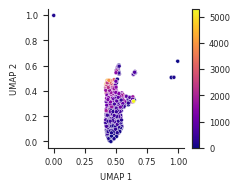

In [9]:
# Plot UMAP, colored according to density of CD3-positive cells in the tumor center (cd3_z)
scatter_plot(df_cd3["UMAP 1"], df_cd3["UMAP 2"], df_cd3["cd3_z"], "../results/umap_CD3imagefeatures_CD3density.svg")

### Visualize features of CD8-stained TMAs from the tumor center using UMAP

In [10]:
cd8_cols = [col for col in tma_expanded.columns if "CD8" in col]
tma_cd8 = tma_expanded[cd8_cols]

In [11]:
umap = UMAP(random_state=42, min_dist=0.1, n_neighbors=15).fit_transform(tma_cd8)
# Normalize axes
tx, ty = umap[:, 0], umap[:, 1]
tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))
df_cd8 = pd.DataFrame()
df_cd8["UMAP 1"] = tx
df_cd8["UMAP 2"] = ty
df_cd8["patient_id"] = id_list
df_cd8 = df_cd8.merge(tma_cell_counts, on="patient_id", how="inner")
df_cd8

,UMAP 1,UMAP 2,patient_id,cd3_z,cd3_inv,cd8_z,cd8_inv
0,0.572402,0.004442,1,1909.950,1027.860,5470.500,4674.550
1,0.362389,0.284281,2,688.920,399.360,570.210,411.505
2,0.442087,0.052172,3,3781.000,2687.500,1556.400,461.490
3,0.503828,0.731916,4,294.595,795.895,119.855,482.065
4,0.171067,0.759653,5,139.020,502.195,55.575,144.050
...,...,...,...,...,...,...,...
728,0.845272,0.897275,759,NaN,2214.100,NaN,NaN
729,0.574801,0.239131,760,1349.550,529.075,1119.020,890.935
730,0.438683,0.248108,761,NaN,1014.110,723.345,1199.950
731,0.588237,0.010445,762,3809.550,890.180,4445.900,2964.750


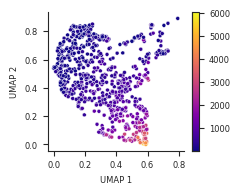

In [12]:
# Plot UMAP, colored according to density of CD3-positive cells in the tumor center (cd8_z)
scatter_plot(df_cd8["UMAP 1"], df_cd8["UMAP 2"], df_cd8["cd8_z"], "../results/umap_CD8imagefeatures_CD8density.svg")